# MESSI Cluster Analysis

This notebook automates the process of computing `kmeans` for single days & 
default features (diff, mean, std), and visualizing the clusters on a Berlin map.

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from IPython.display import display
sns.set_theme()

In [4]:
tmp_ftrs = pd.read_csv("../data/tmp_ftrs.csv")
messi_loc = pd.read_csv("../data/messi_location_clean.csv")

In [14]:
def kmeans_for_single_day(day, n_clusters=4, ftrs=["diff", "mean", "std"]):
    """
    Computes kmean for single day and plots clusters on berlin map.
    """
    # kmeans cannot handle missing values, rows containing missing values are
    # going to be removed
    oneday = tmp_ftrs[tmp_ftrs.day == day].dropna()
    oneday_ftrs = oneday[ftrs].values # convert to numpy array

    # compute kmean
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=10, 
        random_state=42
    ).fit(oneday_ftrs)

    print(
        "kmeans for day #"+str(day),
        "\n\t> SSE =",kmeans.inertia_,
        "\n\t> # of iters =",kmeans.n_iter_,
    )

    # the order of messis does not change, hence, adding labels to dataframe is
    # as simple as:
    oneday["label"] = kmeans.labels_
    # add messi location data -> new data frame for plotting section
    data = oneday.merge(right=messi_loc[["id", "lon", "lat"]], 
                        how="left", on="id")

    # plotting...
    trans = ccrs.PlateCarree() # do not change!
    bg = cimgt.OSM() # background map

    fig, ax = plt.subplots(subplot_kw={"projection": bg.crs})
    ax.set_extent([13.0, 13.7, 52.65, 52.37], crs=trans)
    sns.scatterplot(data=data, x="lon", y="lat", hue="label", style="label",
                    palette="viridis", s=50, linewidth=0.5, ec="k", alpha=0.9,
                    transform=trans, ax=ax) #legend=False
    ax.add_image(bg, 12, alpha=0.9)
    ax.set_title(f"day = {day}")
    fig.savefig(f"../figs/clusters/loc-cluster-{day}.png", dpi=300, 
                bbox_inches="tight")
    plt.close() # to prevent memory overflow

    # save sum of squared distances
    return kmeans.inertia_

In [15]:
days = tmp_ftrs["day"].unique()
sse = {}

for day in days:
    sse[day] = kmeans_for_single_day(day)

kmeans for day #1 
	> SSE = 14.166830409545298 
	> # of iters = 3
kmeans for day #2 
	> SSE = 24.088510195722105 
	> # of iters = 3
kmeans for day #3 
	> SSE = 35.273333095649605 
	> # of iters = 2
kmeans for day #4 
	> SSE = 120.4734868607323 
	> # of iters = 4
kmeans for day #5 
	> SSE = 27.768500550248085 
	> # of iters = 2
kmeans for day #6 
	> SSE = 17.15620576925826 
	> # of iters = 3
kmeans for day #7 
	> SSE = 21.50807781109428 
	> # of iters = 5
kmeans for day #8 
	> SSE = 42.775254353449895 
	> # of iters = 3
kmeans for day #9 
	> SSE = 15.56297038671816 
	> # of iters = 2
kmeans for day #10 
	> SSE = 33.99982905790985 
	> # of iters = 4
kmeans for day #11 
	> SSE = 18.642451740796997 
	> # of iters = 2
kmeans for day #12 
	> SSE = 23.845453020727795 
	> # of iters = 8
kmeans for day #13 
	> SSE = 36.274284559333395 
	> # of iters = 4
kmeans for day #14 
	> SSE = 24.19973253716781 
	> # of iters = 2
kmeans for day #15 
	> SSE = 30.372985737128147 
	> # of iters = 2
kmeans for

Visualizing the inertia (sum of squared distances) of the kmeans-clustering.

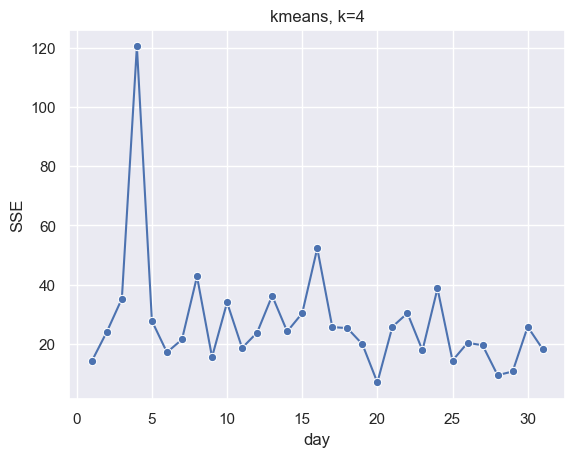

In [16]:
fig, ax = plt.subplots()
sns.lineplot(x=list(sse.keys()), y=list(sse.values()), marker="o")
ax.set_title("kmeans, k=4")
ax.set_xlabel("day")
ax.set_ylabel("SSE");

Creating gif out of maps for single day.

In [19]:
# following approach found here:
# https://towardsdatascience.com/how-to-create-a-gif-from-matplotlib-plots-in-python-6bec6c0c952c#1cac
import imageio

# save single frames into array
frames = []
for day in days:
    image = imageio.v2.imread(f"../figs/clusters/loc-cluster-{day}.png")
    frames.append(image)

# combine frames to gif
imageio.mimsave("../figs/clusters/loc-cluster.gif", frames, duration=1.5)